In [1]:
!pip install reportlab
!pip install fpdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=95e402895a6a4e24763743aec8d0de0db4eac46e8f6db3c8f6091f7fc5948ab8
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera
import seaborn as sns
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
import tempfile
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from fpdf import FPDF

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
font_path = '/content/drive/My Drive/HSBC'
all_files = [os.path.join(font_path, f) for f in os.listdir(font_path) if f.endswith('.csv')]

In [4]:
dataset = os.path.join(font_path, 'Shanghai_Composite_historical_data.csv')
dataset = pd.read_csv(dataset, sep=';')
dataset.head()
print(dataset.columns)

Index(['Price,Open,Close'], dtype='object')


In [5]:
dataset[['Price', 'Open', 'Close']] = dataset['Price,Open,Close'].str.split(',', expand=True)

for col in ['Price', 'Open', 'Close']:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

dataset.drop(columns=['Price,Open,Close'], inplace=True)

print("Updated columns:", dataset.columns)
print(dataset.head())

Updated columns: Index(['Price', 'Open', 'Close'], dtype='object')
   Price         Open        Close
0    NaN          NaN          NaN
1    NaN          NaN          NaN
2    NaN  2497.881104  2465.291016
3    NaN  2461.782959  2464.363037
4    NaN  2446.019043  2514.867920


In [6]:
dataset = dataset.drop(columns=['Price'])

dataset = dataset.dropna()

print(dataset)

             Open        Close
2     2497.881104  2465.291016
3     2461.782959  2464.363037
4     2446.019043  2514.867920
5     2528.698975  2533.089111
6     2530.300049  2526.461914
...           ...          ...
1450  3353.534912  3393.528076
1451  3395.106934  3393.350098
1452  3389.337891  3398.076904
1453  3397.293945  3400.142090
1454  3395.395996  3407.325928

[1453 rows x 2 columns]


Grouped Frequency Distribution:
Bins
(2464.363, 2603.364]     20
(2603.364, 2742.365]     21
(2742.365, 2881.365]    117
(2881.365, 3020.366]    294
(3020.366, 3159.367]    253
(3159.367, 3298.368]    285
(3298.368, 3437.369]    195
(3437.369, 3576.369]    177
(3576.369, 3715.37]      90
Name: count, dtype: int64


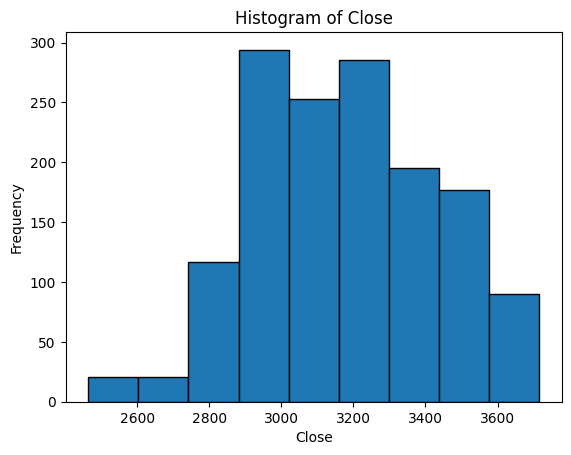

In [7]:
column_to_analyze = 'Close'
dataset = dataset[dataset[column_to_analyze].notnull()].dropna()
dataset[column_to_analyze] = pd.to_numeric(dataset[column_to_analyze], errors='coerce')

# Define bins for the chosen column
bin_ranges = np.linspace(
    dataset[column_to_analyze].min(),
    dataset[column_to_analyze].max(),
    10
)

# Create grouped frequency distribution
dataset['Bins'] = pd.cut(dataset[column_to_analyze], bins=bin_ranges)
frequency_distribution = dataset['Bins'].value_counts().sort_index()

# Display results
print("Grouped Frequency Distribution:")
print(frequency_distribution)

# Plot histogram
plt.hist(dataset[column_to_analyze], bins=bin_ranges, edgecolor='black')
plt.title(f'Histogram of {column_to_analyze}')
plt.xlabel(column_to_analyze)
plt.ylabel('Frequency')
plt.show()
# Save the plot as an image
image_path = "histogram.png"
plt.savefig(image_path)
plt.close()

We should analyse also "Close" column

SD is used by risk analysts to estimate within which a financial instrument or bond returns are likely to fall.

In [13]:
# Compute standard deviation for the 'open' column
std_open = dataset['Open'].std()
print(f"Standard Deviation of 'Open': {std_open}")

# Compute standard deviation for the 'Close' column
std_close = dataset['Close'].std()
print(f"Standard Deviation of 'Close': {std_close}")

Standard Deviation of 'Open': 252.7956828180092
Standard Deviation of 'Close': 251.77826724948815


The skewness (3rd moment) is a measure of the asymmetry of the distribution. In risk measurement, it tells us whether the probability of winning is similar to the probability of losing and the nature of losses. Negative skewness means that there is a substantial probability of a big negative return. Positive skewness means that there is a greater-than-normal probability of a big positive return.

In [9]:
skew_open = dataset['Open'].skew()
print(f"Skewness of 'Open': {skew_open}")

# Compute skewness for the 'Close' column (optional)
skew_close = dataset['Close'].skew()
print(f"Skewness of 'Close': {skew_close}")

def find_if0(skewness):
  if skewness <0:
    print(f"there is a substantial probability of a big negative return")
  if skewness > 0:
    print(f"there is a greater-than-normal probability of a big positive return")
  if skewness == 0:
    print(f"probability of winning is the same as of losing")

print(find_if0(skew_open), find_if0(skew_close))

Skewness of 'Open': -0.014265128385289568
Skewness of 'Close': -0.007918960381280845
there is a substantial probability of a big negative return
there is a substantial probability of a big negative return
None None


Kurtosis is useful in describing extreme events (e.g. losses that are so bad that they only have a 1 in 1000 chance of happening).

In the extreme events, the portfolio with the higher kurtosis would suffer worser losses than the portfolio with lower kurtosis.

In [10]:
# Compute the Coefficient of Variation for the 'Open' column
mean_open = dataset['Open'].mean()
cv_open = (std_open / mean_open) * 100
print(f"Coefficient of Variation for 'Open': {cv_open:.2f}%")

# Compute the Coefficient of Variation for the 'Close' column (optional)
mean_close = dataset['Close'].mean()
cv_close = (std_close / mean_close) * 100
print(f"Coefficient of Variation for 'Close': {cv_close:.2f}%")

kurt_open = dataset['Open'].kurt()
print(f"Kurtosis of 'Open': {kurt_open}")

# Compute Kurtosis for the 'Close' column (optional)
kurt_close = dataset['Close'].kurt()
print(f"Kurtosis of 'Close': {kurt_close}")

def find_if(kurt):
  if kurt <0:
    print(f"distribution is platykurtic , less peakedness and greater coverage of body")
  if kurt > 0:
    print(f"distribution is leptokurtic, fat or long tail but high peakedness")
  if kurt == 0:
    print(f"distribution is mesokurtic , normal shape")

print(find_if(kurt_close), find_if(kurt_open))

Coefficient of Variation for 'Open': 7.97%
Coefficient of Variation for 'Close': 7.93%
Kurtosis of 'Open': -0.6996641387064764
Kurtosis of 'Close': -0.7077488966740395
distribution is platykurtic , less peakedness and greater coverage of body
distribution is platykurtic , less peakedness and greater coverage of body
None None


It is important to note that positive skewness with low kurtosis series promises high returns.


Under the null hypothesis of a normal distribution, the JB statistic is distributed as chi square with two degrees of freedom. The reported probability is the probability that the Jarque-Bera statistic exceeds (in absolute term) the observed value under null. A small probability value (p < 0.05) will reject the null hypothesis of a normal distribution (null is stated here: there cannot be any distribution other than normal). In our case, since computed JB value is lower than the table value (which is 5.991465 at 5% level of significance and with two degrees of freedom), our p-value is quite higher. One can either look at chi-square table or use excel function = CHIINV(5%,2) to obtain the critical values (i.e. the thumb rule that we normally ask to decide). This indicates that we are not able to reject the null hypothesis. If we reject it, we will commit a type I error (i.e. rejecting a true hypothesis) of 55.15%. Hence, our bond value series surely follows normal distribution. A risk manager will have to fit the series this way before it is used to predict the confidence ranges.

In [11]:
jb_stat_open, jb_p_value_open = jarque_bera(dataset['Open'])
print(f"Jarque-Bera statistic for 'Open': {jb_stat_open}")
print(f"p-value for 'Open': {jb_p_value_open}")

# Compute Jarque-Bera test for the 'Close' column (optional)
jb_stat_close, jb_p_value_close = jarque_bera(dataset['Close'])
print(f"Jarque-Bera statistic for 'Close': {jb_stat_close}")
print(f"p-value for 'Close': {jb_p_value_close}")

Jarque-Bera statistic for 'Open': 29.832130633654906
p-value for 'Open': 3.326864717264007e-07
Jarque-Bera statistic for 'Close': 30.48628419673603
p-value for 'Close': 2.3987638750110906e-07


Quantiles for 'Open':
0.00    2446.019043
0.25    2970.808105
0.50    3179.429932
0.75    3367.050049
1.00    3721.086914
Name: Open, dtype: float64
Quantiles for 'Close':
0.00    2464.363037
0.25    2975.479980
0.50    3176.822998
0.75    3367.030029
1.00    3715.370117
Name: Close, dtype: float64


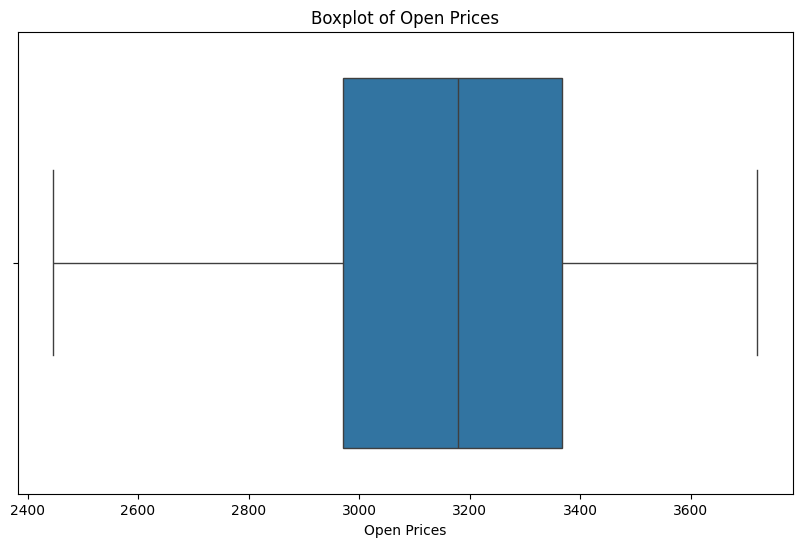

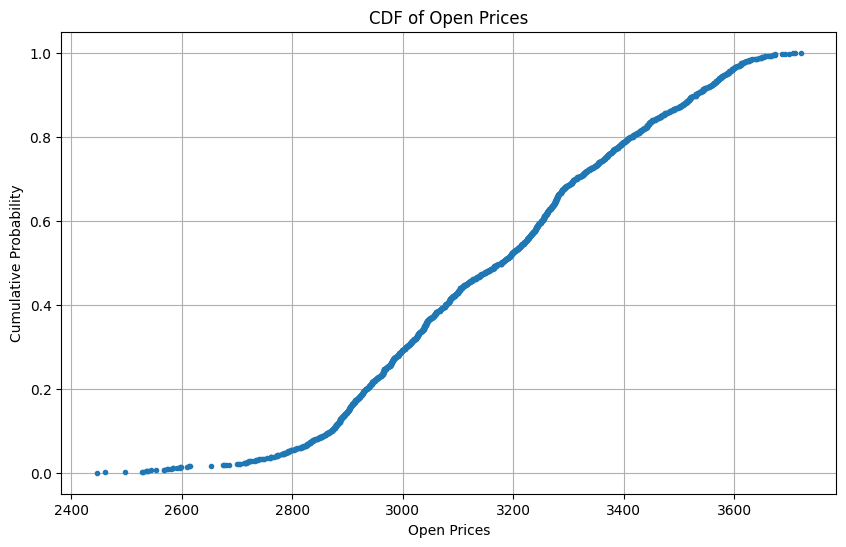

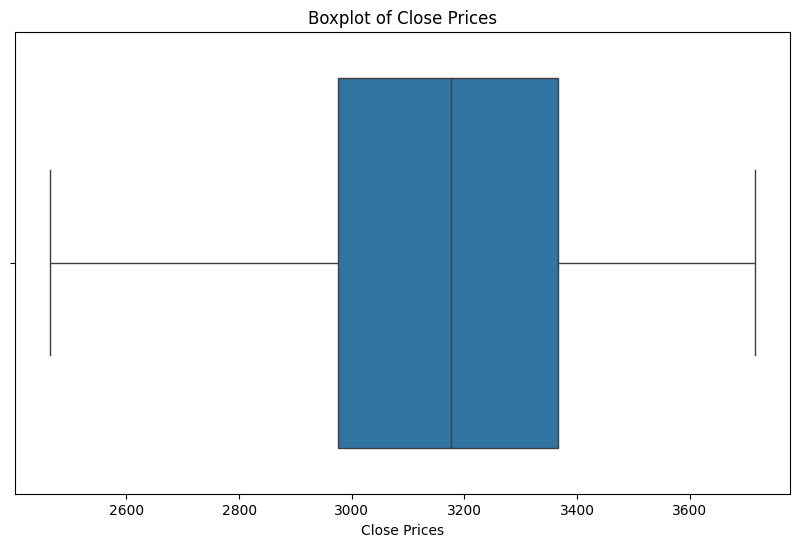

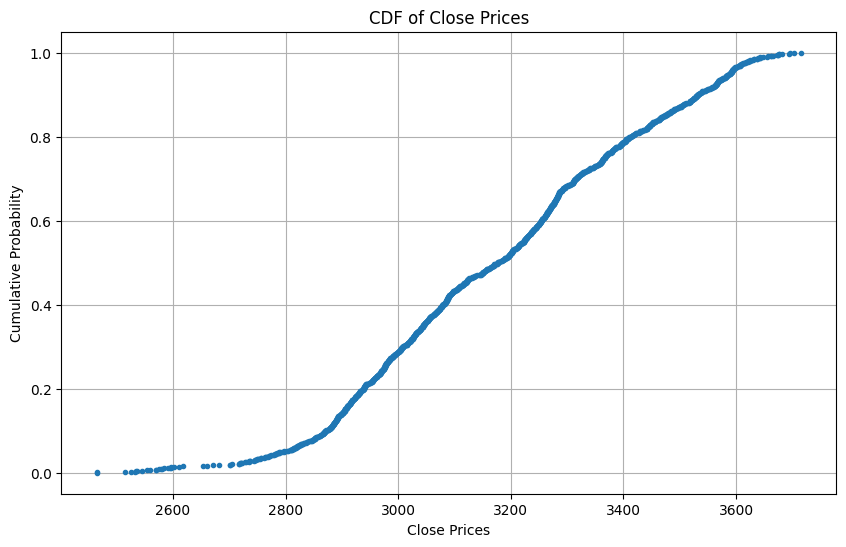

In [12]:
quantiles_open = dataset['Open'].quantile([0, 0.25, 0.5, 0.75, 1])
print(f"Quantiles for 'Open':\n{quantiles_open}")

# Compute quantiles for 'Close' column (optional)
quantiles_close = dataset['Close'].quantile([0, 0.25, 0.5, 0.75, 1])
print(f"Quantiles for 'Close':\n{quantiles_close}")

# Plot Boxplot to visualize quantiles
plt.figure(figsize=(10, 6))
sns.boxplot(x=dataset['Open'])
plt.title('Boxplot of Open Prices')
plt.xlabel('Open Prices')
plt.show()

# Plot CDF (Cumulative Distribution Function)
plt.figure(figsize=(10, 6))
sorted_open = np.sort(dataset['Open'])
cdf_open = np.arange(1, len(sorted_open)+1) / len(sorted_open)
plt.plot(sorted_open, cdf_open, marker='.', linestyle='none')
plt.title('CDF of Open Prices')
plt.xlabel('Open Prices')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=dataset['Close'])
plt.title('Boxplot of Close Prices')
plt.xlabel('Close Prices')
plt.show()

# Plot CDF (Cumulative Distribution Function) for 'Close' prices
plt.figure(figsize=(10, 6))
sorted_close = np.sort(dataset['Close'])
cdf_close = np.arange(1, len(sorted_close) + 1) / len(sorted_close)
plt.plot(sorted_close, cdf_close, marker='.', linestyle='none')
plt.title('CDF of Close Prices')
plt.xlabel('Close Prices')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()


Gini coefficient is used as a measure of inequality in loan distribution across borrowers, industries, regions, etc. This inequality measures loan concentration risk. Thus, higher is the Gini coefficient, greater is the inequality, and greater is the concentration risk. It is also used to measure discriminatory power of a rating model during model validation.




Gini Coefficient for 'Open': 0.083236
Gini Coefficient for 'Close': 0.083266


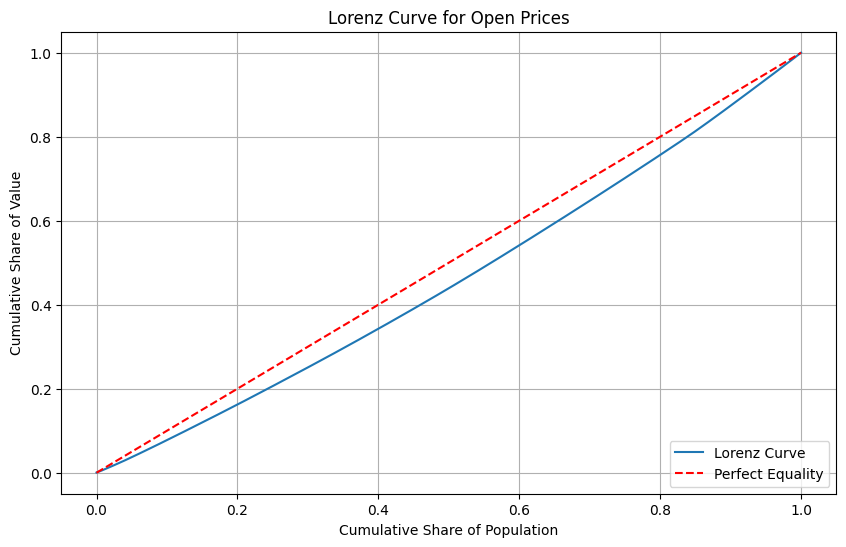

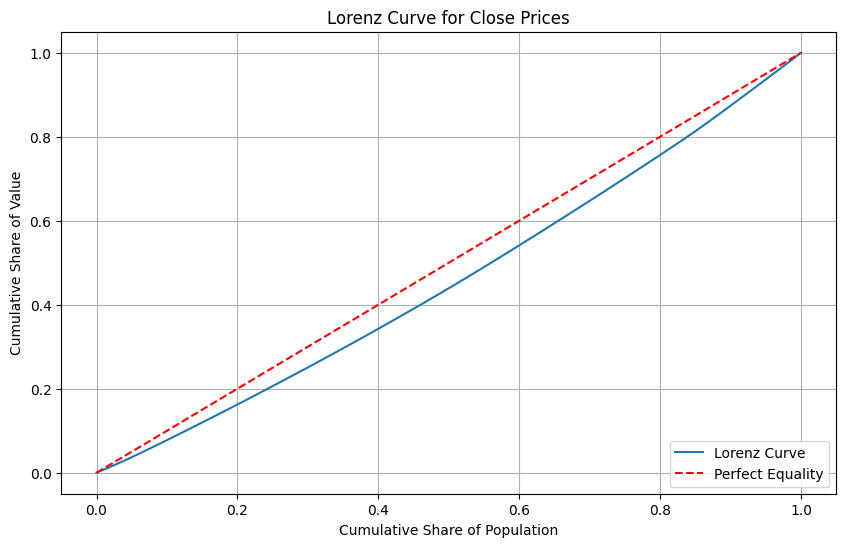

In [43]:
def gini_coefficient(values):
    # Ensure values are non-negative and sorted
    sorted_values = np.sort(values)  # Sort the values
    n = len(values)  # Number of values

    if n == 0:
        return 0  # Handle empty input gracefully

    if np.any(values < 0):
        raise ValueError("Values must be non-negative for Gini coefficient calculation.")

    # Compute cumulative sum
    cumulative_sum = np.cumsum(sorted_values)

    # Compute the Gini coefficient
    numerator = np.sum((2 * np.arange(1, n + 1) - n - 1) * sorted_values)
    denominator = n * np.sum(sorted_values)

    if denominator == 0:
        return 0  # Avoid division by zero if all values are zero

    gini = numerator / denominator
    return gini

# Example usage:
# Assuming `dataset` is a DataFrame with columns 'Open' and 'Close'
gini_open = gini_coefficient(dataset['Open'].values)
print(f"Gini Coefficient for 'Open': {gini_open:.6f}")

gini_close = gini_coefficient(dataset['Close'].values)
print(f"Gini Coefficient for 'Close': {gini_close:.6f}")

# Plot Lorenz Curve for 'Open' prices
sorted_open = np.sort(dataset['Open'])
cumulative_open = np.cumsum(sorted_open) / np.sum(sorted_open)

# Add the line for perfect equality
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0.0, 1.0, len(sorted_open)), cumulative_open, label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Perfect Equality')
plt.title('Lorenz Curve for Open Prices')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Value')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Lorenz Curve for 'Close' prices (optional)
sorted_close = np.sort(dataset['Close'])
cumulative_close = np.cumsum(sorted_close) / np.sum(sorted_close)

# Add the line for perfect equality
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0.0, 1.0, len(sorted_close)), cumulative_close, label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Perfect Equality')
plt.title('Lorenz Curve for Close Prices')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Value')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
